## OCTAM Data Analysis

In [3]:
# import libraries
import os
import glob
import math
import pandas as pd 
import numpy as np 
import matplotlib.pylab as plt
import plotly.express as px
from datetime import datetime
import geopandas as gpd
from shapely.geometry import Point
import folium
plt.style.use('ggplot')

## Laod OCTAM Raw Shapefile Data 

- Load OCTAM shapefile from raw_data
- Save them to parquet files

### Data Structure

- All three years data is now stored in dictionary
- Name of dictionary: `{scope}_{class}_{datatype}`
    - scope: `OCTAM`, `ROUTES`
    - class: `raw`, `trimmed`
    - datatype: `shp`, `parquet`, `gdf`, `df`
- Key of dictionary: `BY2019`, `NB2045`, `BO2045`
- crs is: `EPSG:4019`

### Save shapefile to parquet

- save disk space and time

In [415]:
# Load raw data
# take two minutes to load
OCTAM_BY2019_shp = gpd.read_file('raw_data/OCTAM_Links_19BY.shp')
OCTAM_NB2045_shp = gpd.read_file('raw_data/OCTAM_Links_45NB.shp')
OCTAM_BO2045_shp = gpd.read_file('raw_data/OCTAM_Links_45BO.shp')

In [416]:
OCTAM_raw_shp = {'BY2019': OCTAM_BY19_shp, 'NB2045': OCTAM_NB45_shp, 'BO2045': OCTAM_BO45_shp}

In [427]:
# save OCTAM raw shapefiles to parquet
for key in OCTAM_raw_shp.keys():
    OCTAM_raw_shp[key].to_parquet(f'raw_data/OCTAM_{key}_raw.parquet')

## Read OCTAM Raw Parquet Files

- use `gpd.read_parquet()` so the geometry columns stay the same

### Trim the columns

In [428]:
# read OCTAM raw parquet
years = ['BY2019', 'NB2045', 'BO2045']
OCTAM_raw_parquet = {}
for i in years:
    OCTAM_raw_parquet[i] = gpd.read_parquet(f'raw_data/OCTAM_{i}_raw.parquet')

In [431]:
# trim columns
OCTAM_trimmed_parquet = {}
for key, value in OCTAM_raw_parquet.items():
    OCTAM_trimmed_parquet[key] = (
        OCTAM_raw_parquet[key][
            [
                "ID",
                "AB_CAP_DY",
                "AB_COM_LVO",
                "BA_COM_LVO",
                "TOT_COM_LV",
                "AB_COM_LV1",
                "BA_COM_LV1",
                "TOT_COM_L1",
                "AB_COM_LV2",
                "BA_COM_LV2",
                "TOT_COM_L2",
                "ROADWAY_NA",
                "geometry",
            ]
        ]
        .copy()
        .rename(
            columns={
                "ID": "ID",
                "AB_CAP_DY": "CAPACITY",
                "AB_COM_LVO": "AB_AMVOL",
                "BA_COM_LVO": "BA_AMVOL",
                "TOT_COM_LV": "TOT_AMVOL",
                "AB_COM_LV1": "AB_PMVOL",
                "BA_COM_LV1": "BA_PMVOL",
                "TOT_COM_L1": "TOT_PMVOL",
                "AB_COM_LV2": "AB_TOTVOL",
                "BA_COM_LV2": "BA_TOTVOL",
                "TOT_COM_L2": "TOT_VOL",
                "ROADWAY_NA": "RT_NAME",
                "geometry": "geometry",
            }
        )
    )


In [432]:
# save trimmed parquet
for key in OCTAM_trimmed_parquet.keys():
    OCTAM_trimmed_parquet[key].to_parquet(f'data/OCTAM_{key}_trimmed.parquet')

In [436]:
OCTAM_trimmed_parquet['BO2045'][OCTAM_trimmed_parquet['BY2019']['ID']==20635]

,ID,CAPACITY,AB_AMVOL,BA_AMVOL,TOT_AMVOL,AB_PMVOL,BA_PMVOL,TOT_PMVOL,AB_TOTVOL,BA_TOTVOL,TOT_VOL,RT_NAME,geometry
17386,20635,37500.0,1910.4627,3936.2529,5846.7156,4615.4026,2217.5099,6832.9126,9102.3414,8884.2576,17986.599,ORTEGA HWY,"LINESTRING (-117.54136 33.57337, -117.54109 33..."


## Extract SR 74 from OCTAM trimmed gdf

In [437]:
SR74_gdf = {}
for key in OCTAM_trimmed_parquet.keys():
    SR74_gdf[key] = OCTAM_trimmed_parquet[key].loc[OCTAM_trimmed_parquet[key]['RT_NAME'].notna()].loc[OCTAM_trimmed_parquet[key]['RT_NAME']=='ORTEGA HWY']
    SR74_gdf[key].to_parquet(f"data/SR74_{key}_gdf.parquet")

In [440]:
SR74_gdf['BO2045'].loc[SR74_gdf['BO2045']['ID']==20635]

,ID,CAPACITY,AB_AMVOL,BA_AMVOL,TOT_AMVOL,AB_PMVOL,BA_PMVOL,TOT_PMVOL,AB_TOTVOL,BA_TOTVOL,TOT_VOL,RT_NAME,geometry
17386,20635,37500.0,1910.4627,3936.2529,5846.7156,4615.4026,2217.5099,6832.9126,9102.3414,8884.2576,17986.599,ORTEGA HWY,"LINESTRING (-117.54136 33.57337, -117.54109 33..."


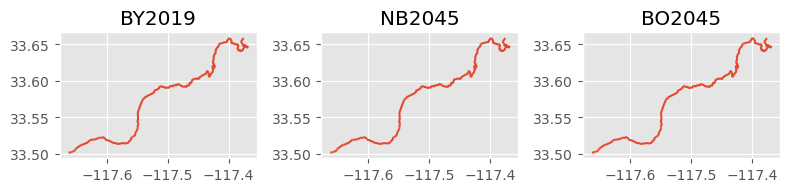

In [448]:
# check SR 74 BY2019 covers the whole SR 74
fig, axs = plt.subplots(ncols=3, figsize=(8, 10))

for i, (key, df) in enumerate(SR74_gdf.items()):
    ax = axs[i]
    df.plot(ax=ax)
    ax.set_title(key)
fig.tight_layout()

## Load Postmile Raw Shapefile
### Data Wrangling

- Extract Needed Columns
- Conveert to crs `EPSG:4019`
- Save as parquet

In [449]:
postmile_shp = gpd.read_file('raw_data/SHN_Tenth_Postmiles_OC_select.shp')

In [453]:
# Extract Needed Columns
# Conveert to crs `EPSG:4019`
postmile_trimmed_gdf = postmile_shp[
    [
        "OBJECTID",
        "ROUTE",
        "ROUTEID",
        "COUNTY",
        "DISTRICT",
        "PMPREFIX",
        "PM",
        "PMSUFFIX",
        "PMC",
        "ALIGNCODE",
        "Lat_WGS84",
        "Long_WGS84",
    ]
].copy()
postmile_trimmed_gdf['geometry'] = postmile_df.apply(lambda row: Point(row.Long_WGS84, row.Lat_WGS84), axis=1)
postmile_trimmed_gdf = gpd.GeoDataFrame(postmile_df, geometry='geometry')
postmile_trimmed_gdf.crs = 'EPSG:4019'

In [454]:
# save to parquet
postmile_trimmed_gdf.to_parquet('data/postmile_trimmed_gdf.parquet')

In [455]:
postmile_trimmed_gdf.head(5)

,OBJECTID,ROUTE,ROUTEID,COUNTY,DISTRICT,PMPREFIX,PM,PMSUFFIX,PMC,ALIGNCODE,Lat_WGS84,Long_WGS84,geometry
0,191,1,1_20171231_L,ORA,12,NaN,9.5,NaN,9.5,Left,33.543171,-117.786628,POINT (-117.78663 33.54317)
1,805,1,1_20171231_L,ORA,12,NaN,17.5,NaN,17.5,Left,33.612819,-117.891706,POINT (-117.89171 33.61282)
2,991,1,1_20171231_L,ORA,12,NaN,26.5,NaN,26.5,Left,33.674212,-118.025442,POINT (-118.02544 33.67421)
3,1127,1,1_20171231_L,ORA,12,NaN,30.6,NaN,30.6,Left,33.718914,-118.071566,POINT (-118.07157 33.71891)
4,1602,1,1_20171231_L,ORA,12,NaN,25.5,NaN,25.5,Left,33.664521,-118.012269,POINT (-118.01227 33.66452)


## Extract SR 74 postmile from postmile trimmed gdf

- Check the number of rows are equal for Left and Right for SR74
- Export to parquet: `SR74_postmile_gdf.parquet`

In [472]:
# make sure the number of rows are equal for Left and Right
len(
    postmile_trimmed_gdf.loc[
        (postmile_trimmed_gdf["ALIGNCODE"] == "Right")
        & (postmile_trimmed_gdf["ROUTE"] == 74)
    ]
) == len(
    postmile_trimmed_gdf.loc[
        (postmile_trimmed_gdf["ALIGNCODE"] == "Left")
        & (postmile_trimmed_gdf["ROUTE"] == 74)
    ]
)


True

In [465]:
# extract SR74 and save as parquet
SR74_postmile_gdf = postmile_gdf.loc[
    (postmile_gdf["ALIGNCODE"] == "Right") & (postmile_gdf["ROUTE"] == 74)
]
SR74_postmile_gdf.to_parquet("data/SR74_postmile_gdf.parquet")


## Load Trimmed Parquet

- `SR74_gdf` dictionary from `data/SR74_{i}_gdf.parquet`
- `SR74_postmile_gdf` GeoDataFrame from `data/SR74_postmile_gdf.parquet`

In [467]:
# load trimmed parquet
SR74_gdf = {}
OCTAM_years = ['BY2019', 'NB2045', 'BO2045']
for i in OCTAM_years:
    SR74_gdf[i] = gpd.read_parquet(f"data/SR74_{i}_gdf.parquet")

In [479]:
SR74_postmile_gdf = gpd.read_parquet(f"data/SR74_postmile_gdf.parquet")

## Plotting in folium map before joining

In [475]:
def plot_gdf_with_popups(gdf, attribute):
    center = [gdf['geometry'].centroid.y.mean(), gdf['geometry'].centroid.x.mean()]
    m = folium.Map(location=center, zoom_start=12)
    folium.GeoJson(gdf, name='My Shapefile', \
        tooltip=folium.features.GeoJsonTooltip(fields=[attribute]), \
        style_function=lambda feature: {'color': 'blue','weight': 3}, \
        highlight_function=lambda x: {'weight': 3}).add_to(m)
    return(m)

In [476]:
plot_gdf_with_popups(SR74_postmile_gdf, 'PM')

/var/folders/zw/0qm25w_977d1zq7kcs7rj93c0000gn/T/ipykernel_65842/1163662230.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = [gdf['geometry'].centroid.y.mean(), gdf['geometry'].centroid.x.mean()]
/var/folders/zw/0qm25w_977d1zq7kcs7rj93c0000gn/T/ipykernel_65842/1163662230.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = [gdf['geometry'].centroid.y.mean(), gdf['geometry'].centroid.x.mean()]


In [ ]:
plot_gdf_with_popups(SR74_postmile_gdf, 'PM')

## Plotting shapefiles in folium map
- [X] create an function to show the maps 

The final cleaned gdfs are `SR74_BY2019_gdf` and `pm_74_gdf`

In [79]:
def plot_gdfs_on_map(gdfs):
    center_lat = 0
    center_lon = 0
    num_points = 0
    for gdf in gdfs:
        center_lat += gdf['geometry'].centroid.y.mean()
        center_lon += gdf['geometry'].centroid.x.mean()
        num_points += len(gdf)
    center_lat /= len(gdfs)
    center_lon /= len(gdfs)
    center = [center_lat, center_lon]
    m = folium.Map(location=center, zoom_start=12)
    for gdf in gdfs:
        folium.GeoJson(gdf).add_to(m)
    return m

In [81]:
sr74_pm_BY2019_gdfs = [SR74_BY2019_gdf, pm_74_gdf]
plot_gdfs_on_map(sr74_pm_BY2019_gdfs)

/var/folders/zw/0qm25w_977d1zq7kcs7rj93c0000gn/T/ipykernel_54631/1033600962.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lat += gdf['geometry'].centroid.y.mean()
/var/folders/zw/0qm25w_977d1zq7kcs7rj93c0000gn/T/ipykernel_54631/1033600962.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lon += gdf['geometry'].centroid.x.mean()
/var/folders/zw/0qm25w_977d1zq7kcs7rj93c0000gn/T/ipykernel_54631/1033600962.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lat += gdf['geometry'].centroid.y.mean()
/var/folders/zw/0qm25w_977d1zq7kcs7rj93c0000gn/T/

## Spatial Join Postmile and BY2019

In [481]:
SR74_joined_gdf = {}
for key in SR74_gdf.keys():
    SR74_joined_gdf[key] = gpd.sjoin_nearest(SR74_postmile_gdf, SR74_gdf[key], how='inner', distance_col='distance')

/Users/yu-jenchen/miniforge3/envs/py4ds/lib/python3.11/site-packages/geopandas/array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/yu-jenchen/miniforge3/envs/py4ds/lib/python3.11/site-packages/geopandas/array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/yu-jenchen/miniforge3/envs/py4ds/lib/python3.11/site-packages/geopandas/array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [484]:
SR74_joined_gdf['BY2019'].columns

Index(['OBJECTID', 'ROUTE', 'ROUTEID', 'COUNTY', 'DISTRICT', 'PMPREFIX', 'PM',
       'PMSUFFIX', 'PMC', 'ALIGNCODE', 'Lat_WGS84', 'Long_WGS84', 'geometry',
       'index_right', 'ID', 'CAPACITY', 'AB_AMVOL', 'BA_AMVOL', 'TOT_AMVOL',
       'AB_PMVOL', 'BA_PMVOL', 'TOT_PMVOL', 'AB_TOTVOL', 'BA_TOTVOL',
       'TOT_VOL', 'RT_NAME', 'distance'],
      dtype='object')

In [493]:
# Assign Section based on PM
def cmcp_section(pm):
    if pm <=2.6:
        return 1
    elif 2.6 < pm <= 7.2:
        return 2
    else:
        return 3

In [494]:
for key in SR74_joined_gdf.keys():
    SR74_joined_gdf[key] = SR74_joined_gdf[key][
        [
            "ID",
            "OBJECTID",
            "ROUTE",
            "ROUTEID",
            "COUNTY",
            "DISTRICT",
            "PMPREFIX",
            "PM",
            "PMSUFFIX",
            "PMC",
            "CAPACITY",
            "AB_AMVOL",
            "BA_AMVOL",
            "TOT_AMVOL",
            "AB_PMVOL",
            "BA_PMVOL",
            "TOT_PMVOL",
            "AB_TOTVOL",
            "BA_TOTVOL",
            "TOT_VOL",
            "Lat_WGS84",
            "Long_WGS84",
            "geometry",
        ]
    ].sort_values('PM', ascending=True).copy()
    SR74_joined_gdf[key]['SECTION'] = np.vectorize(cmcp_section)(SR74_joined_gdf[key]['PM'])
     SR74_joined_gdf[key].to_parquet(f'data/SR74_{key}_joined.parquet')


In [509]:
# read joined parquet file
years = ['BY2019', 'NB2045', 'BO2045']
SR74_joined_gdf = {}
for i in years:
    SR74_joined_gdf[i] = gpd.read_parquet(f'data/SR74_{i}_joined.parquet')

In [510]:
 SR74_joined_gdf['BY2019'].head(5)

,ID,OBJECTID,ROUTE,ROUTEID,COUNTY,DISTRICT,PMPREFIX,PM,PMSUFFIX,PMC,...,AB_PMVOL,BA_PMVOL,TOT_PMVOL,AB_TOTVOL,BA_TOTVOL,TOT_VOL,Lat_WGS84,Long_WGS84,geometry,SECTION
2786,25378,263415,74,74_20171231_R,ORA,12,None,0.0,None,0,...,4783.4618,11179.4510,15962.912,25620.0,25620.000,51240.000,33.502510,-117.658487,POINT (-117.65849 33.50251),1
3485,20622,259961,74,74_20171231_R,ORA,12,None,0.1,None,0.1,...,7249.0398,7937.6305,15186.670,25620.0,25620.000,51240.000,33.502961,-117.656925,POINT (-117.65692 33.50296),1
5683,20622,262293,74,74_20171231_R,ORA,12,None,0.2,None,0.2,...,7249.0398,7937.6305,15186.670,25620.0,25620.000,51240.000,33.503350,-117.655417,POINT (-117.65542 33.50335),1
3469,20621,258833,74,74_20171231_R,ORA,12,None,0.3,None,0.3,...,6432.5474,4058.6592,10491.206,17850.0,17044.168,34894.168,33.503892,-117.653872,POINT (-117.65387 33.50389),1
5670,20621,261164,74,74_20171231_R,ORA,12,None,0.4,None,0.4,...,6432.5474,4058.6592,10491.206,17850.0,17044.168,34894.168,33.504810,-117.652473,POINT (-117.65247 33.50481),1


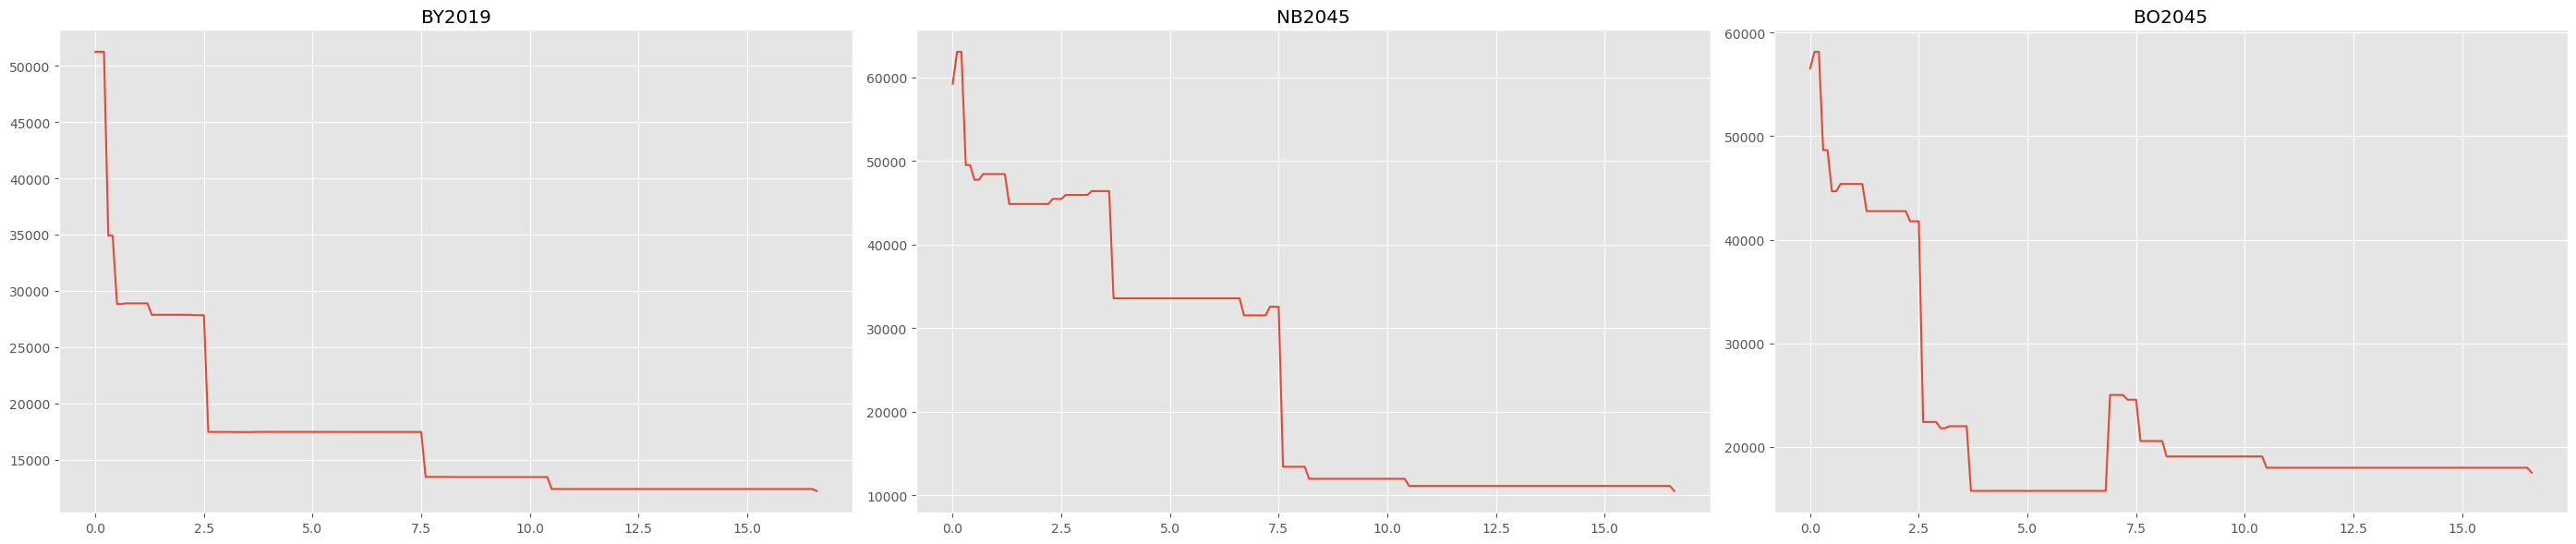

In [505]:
# check SR 74 BY2019 covers the whole SR 74
fig, axs = plt.subplots(ncols=3, figsize=(28, 6))

for i, (key, df) in enumerate(SR74_joined_gdf.items()):
    ax = axs[i]
    ax.plot(df['PM'], df['TOT_VOL'])
    ax.set_title(key)
fig.tight_layout()

## Traffic Data Analysis

- Combine the dataframe in dictionary `SR74_joined_gdf`
#### Sections 
1. PM 0.00 - 2.60
2. PM 2.60 - 7.20
3. PM 7.20 - 16.60


In [512]:
SR74_joined_gdf['NB'].columns

Index(['ID', 'OBJECTID', 'ROUTE', 'ROUTEID', 'COUNTY', 'DISTRICT', 'PMPREFIX',
       'PM', 'PMSUFFIX', 'PMC', 'CAPACITY', 'AB_AMVOL', 'BA_AMVOL',
       'TOT_AMVOL', 'AB_PMVOL', 'BA_PMVOL', 'TOT_PMVOL', 'AB_TOTVOL',
       'BA_TOTVOL', 'TOT_VOL', 'Lat_WGS84', 'Long_WGS84', 'geometry',
       'SECTION'],
      dtype='object')

In [514]:
for key in SR74_joined_gdf.keys():
    SR74_joined_gdf[key] = SR74_joined_gdf[key][
        [
            "ID",
            "OBJECTID",
            "ROUTE",
            "PMPREFIX",
            "PM",
            "PMC",
            "SECTION",
            "CAPACITY",
            "AB_AMVOL",
            "BA_AMVOL",
            "TOT_AMVOL",
            "AB_PMVOL",
            "BA_PMVOL",
            "TOT_PMVOL",
            "AB_TOTVOL",
            "BA_TOTVOL",
            "TOT_VOL",
            "Lat_WGS84",
            "Long_WGS84",
            "geometry",
        ]
    ].copy()
    SR74_joined_gdf[key] = SR74_joined_gdf[key].rename(
        columns={
            "CAPACITY": f"{key}_CAPACITY",
            "AB_AMVOL": f"{key}_AB_AMVOL",
            "BA_AMVOL": f"{key}_BA_AMVOL",
            "TOT_AMVOL": f"{key}_TOT_AMVOL",
            "AB_PMVOL": f"{key}_AB_PMVOL",
            "BA_PMVOL": f"{key}_BA_PMVOL",
            "TOT_PMVOL": f"{key}_TOT_PMVOL",
            "AB_TOTVOL": f"{key}_AB_TOTVOL",
            "BA_TOTVOL": f"{key}_BA_TOTVOL",
            "TOT_VOL": f"{key}_TOTVOL",
        }
    ).copy()


In [516]:
for key in SR74_joined_gdf.keys():
    print(SR74_joined_gdf[key].columns)

Index(['ID', 'OBJECTID', 'ROUTE', 'PMPREFIX', 'PM', 'PMC', 'SECTION',
       'BY2019_CAPACITY', 'BY2019_AB_AMVOL', 'BY2019_BA_AMVOL',
       'BY2019_TOT_AMVOL', 'BY2019_AB_PMVOL', 'BY2019_BA_PMVOL',
       'BY2019_TOT_PMVOL', 'BY2019_AB_TOTVOL', 'BY2019_BA_TOTVOL',
       'BY2019_TOTVOL', 'Lat_WGS84', 'Long_WGS84', 'geometry'],
      dtype='object')
Index(['ID', 'OBJECTID', 'ROUTE', 'PMPREFIX', 'PM', 'PMC', 'SECTION',
       'NB2045_CAPACITY', 'NB2045_AB_AMVOL', 'NB2045_BA_AMVOL',
       'NB2045_TOT_AMVOL', 'NB2045_AB_PMVOL', 'NB2045_BA_PMVOL',
       'NB2045_TOT_PMVOL', 'NB2045_AB_TOTVOL', 'NB2045_BA_TOTVOL',
       'NB2045_TOTVOL', 'Lat_WGS84', 'Long_WGS84', 'geometry'],
      dtype='object')
Index(['ID', 'OBJECTID', 'ROUTE', 'PMPREFIX', 'PM', 'PMC', 'SECTION',
       'BO2045_CAPACITY', 'BO2045_AB_AMVOL', 'BO2045_BA_AMVOL',
       'BO2045_TOT_AMVOL', 'BO2045_AB_PMVOL', 'BO2045_BA_PMVOL',
       'BO2045_TOT_PMVOL', 'BO2045_AB_TOTVOL', 'BO2045_BA_TOTVOL',
       'BO2045_TOTVOL', 'Lat_W

In [525]:
for key in SR74_joined_gdf.keys():
    print(SR74_joined_gdf[key].columns)


Index(['ID', 'OBJECTID', 'ROUTE', 'PMPREFIX', 'PM', 'PMC', 'SECTION',
       'BY2019_CAPACITY', 'BY2019_AB_AMVOL', 'BY2019_BA_AMVOL',
       'BY2019_TOT_AMVOL', 'BY2019_AB_PMVOL', 'BY2019_BA_PMVOL',
       'BY2019_TOT_PMVOL', 'BY2019_AB_TOTVOL', 'BY2019_BA_TOTVOL',
       'BY2019_TOTVOL', 'Lat_WGS84', 'Long_WGS84', 'geometry'],
      dtype='object')
Index(['ID', 'OBJECTID', 'ROUTE', 'PMPREFIX', 'PM', 'PMC', 'SECTION',
       'NB2045_CAPACITY', 'NB2045_AB_AMVOL', 'NB2045_BA_AMVOL',
       'NB2045_TOT_AMVOL', 'NB2045_AB_PMVOL', 'NB2045_BA_PMVOL',
       'NB2045_TOT_PMVOL', 'NB2045_AB_TOTVOL', 'NB2045_BA_TOTVOL',
       'NB2045_TOTVOL', 'Lat_WGS84', 'Long_WGS84', 'geometry'],
      dtype='object')
Index(['ID', 'OBJECTID', 'ROUTE', 'PMPREFIX', 'PM', 'PMC', 'SECTION',
       'BO2045_CAPACITY', 'BO2045_AB_AMVOL', 'BO2045_BA_AMVOL',
       'BO2045_TOT_AMVOL', 'BO2045_AB_PMVOL', 'BO2045_BA_PMVOL',
       'BO2045_TOT_PMVOL', 'BO2045_AB_TOTVOL', 'BO2045_BA_TOTVOL',
       'BO2045_TOTVOL', 'Lat_W

In [531]:
SR74_master_df = None
for key in SR74_joined_gdf:
    if SR74_master_df is None:
        SR74_master_df = SR74_joined_gdf[key]
    else:
        SR74_master_df = pd.merge(
            SR74_master_df,
            SR74_joined_gdf[key][
                [
                    "OBJECTID",
                    f"{key}_CAPACITY",
                    f"{key}_AB_AMVOL",
                    f"{key}_BA_AMVOL",
                    f"{key}_TOT_AMVOL",
                    f"{key}_AB_PMVOL",
                    f"{key}_BA_PMVOL",
                    f"{key}_TOT_PMVOL",
                    f"{key}_AB_TOTVOL",
                    f"{key}_BA_TOTVOL",
                    f"{key}_TOTVOL",
                ]
            ],
            on="OBJECTID",
            how="inner",
        )


In [532]:
SR74_master_df

,ID,OBJECTID,ROUTE,PMPREFIX,PM,PMC,SECTION,BY2019_CAPACITY,BY2019_AB_AMVOL,BY2019_BA_AMVOL,...,BO2045_CAPACITY,BO2045_AB_AMVOL,BO2045_BA_AMVOL,BO2045_TOT_AMVOL,BO2045_AB_PMVOL,BO2045_BA_PMVOL,BO2045_TOT_PMVOL,BO2045_AB_TOTVOL,BO2045_BA_TOTVOL,BO2045_TOTVOL
0,25378,263415,74,None,0.0,0,1,46900.0,2909.2464,8122.9587,...,46900.0,2584.6754,8574.946,11159.621,5247.1642,12158.702,17405.867,26185.375,30358.024,56543.399


In [536]:
# save to parquet (requires pyarrow library)
SR74_master_df.to_parquet('data/SR74_master_df.parquet')

In [537]:
SR74_results = (
    SR74_master_df[
        [
            "SECTION",
            "BY2019_CAPACITY",
            "NB2045_CAPACITY",
            "BO2045_CAPACITY", 
            "BY2019_TOTVOL",
            "NB2045_TOTVOL",
            "BO2045_TOTVOL",
            "BY2019_TOT_AMVOL",
            "NB2045_TOT_AMVOL",
            "BO2045_TOT_AMVOL",
            "BY2019_TOT_PMVOL",
            "NB2045_TOT_PMVOL",
            "BO2045_TOT_PMVOL",
            "BY2019_AB_AMVOL",
            "NB2045_AB_AMVOL",
            "BO2045_AB_AMVOL",
            "BY2019_BA_AMVOL",
            "NB2045_BA_AMVOL",
            "BO2045_BA_AMVOL",
            "BY2019_AB_PMVOL",
            "NB2045_AB_PMVOL",
            "BO2045_AB_PMVOL",
            "BY2019_BA_PMVOL",
            "NB2045_BA_PMVOL",
            "BO2045_BA_PMVOL",
        ]
    ]
    .groupby(["SECTION"])
    .mean()
    .reset_index()
)

In [538]:
SR74_results

,SECTION,BY2019_CAPACITY,NB2045_CAPACITY,BO2045_CAPACITY,BY2019_TOTVOL,NB2045_TOTVOL,BO2045_TOTVOL,BY2019_TOT_AMVOL,NB2045_TOT_AMVOL,BO2045_TOT_AMVOL,...,BO2045_AB_AMVOL,BY2019_BA_AMVOL,NB2045_BA_AMVOL,BO2045_BA_AMVOL,BY2019_AB_PMVOL,NB2045_AB_PMVOL,BO2045_AB_PMVOL,BY2019_BA_PMVOL,NB2045_BA_PMVOL,BO2045_BA_PMVOL
0,1,31382.758621,31382.758621,39120.689655,30681.239069,47975.772483,44573.711379,6754.839690,9160.997962,9773.801507,...,4373.748400,3884.571517,5031.512531,5400.053259,5167.632803,6418.467203,6948.900621,4374.678048,5926.250817,6525.781372
1,2,20222.916667,20222.916667,37500.000000,17453.825229,36452.169313,18117.598083,5626.690596,9928.709617,6289.939392,...,4083.247252,1923.687806,3917.215667,2206.692110,2297.528706,5291.559310,2684.469483,4309.563600,7283.980677,4188.485354
2,3,18800.000000,18800.000000,37298.924731,12873.118484,12146.116495,18629.396495,4151.667534,3854.153190,6041.373348,...,2544.551835,2638.744951,2058.301617,3496.821509,3083.736439,2252.914515,4102.474356,1809.130913,1943.200596,2971.375581


In [539]:
SR74_results.to_parquet('data/SR74_results.parquet')

In [552]:
# AADT Growth Rate 
report_results_df = SR74_results[['SECTION', 'BY2019_CAPACITY', 'NB2045_CAPACITY', 'BO2045_CAPACITY', 'BY2019_TOTVOL', 'NB2045_TOTVOL', 'BO2045_TOTVOL']].copy()
report_results_df = pd.concat([report_results_df, 100*(np.exp(np.log(SR74_results['NB2045_TOTVOL']/SR74_results['BY2019_TOTVOL'])/26)-1).rename('NB_GR')], axis=1)
report_results_df = pd.concat([report_results_df, 100*(np.exp(np.log(SR74_results['BO2045_TOTVOL']/SR74_results['BY2019_TOTVOL'])/26)-1).rename('BO_GR')], axis=1)
report_results_df

,SECTION,BY2019_CAPACITY,NB2045_CAPACITY,BO2045_CAPACITY,BY2019_TOTVOL,NB2045_TOTVOL,BO2045_TOTVOL,NB_GR,BO_GR
0,1,31382.758621,31382.758621,39120.689655,30681.239069,47975.772483,44573.711379,1.734270,1.446879
1,2,20222.916667,20222.916667,37500.000000,17453.825229,36452.169313,18117.598083,2.872966,0.143660
2,3,18800.000000,18800.000000,37298.924731,12873.118484,12146.116495,18629.396495,-0.223334,1.431688


In [553]:
# Peak Hour AADT
peak_hour_aadt = pd.DataFrame()
peak_hour_aadt['BY2019_TOT_AMPMVOL'] = SR74_results['BY2019_TOT_AMVOL'] + SR74_results['BY2019_TOT_PMVOL']
peak_hour_aadt['NB2045_TOT_AMPMVOL'] = SR74_results['NB2045_TOT_AMVOL'] + SR74_results['NB2045_TOT_PMVOL']
peak_hour_aadt['BO2045_TOT_AMPMVOL'] = SR74_results['BO2045_TOT_AMVOL'] + SR74_results['BO2045_TOT_PMVOL']
peak_hour_aadt
# result_df = pd.concat([result_df, 100*(np.exp(np.log(SR74_result['NB2045_TOTVOL']/SR74_result['BY2019_TOTVOL'])/26)-1).rename('NB_GR')], axis=1)

,BY2019_TOT_AMPMVOL,NB2045_TOT_AMPMVOL,BO2045_TOT_AMPMVOL
0,16297.150459,21505.715893,23248.483224
1,12233.782906,22504.249325,13162.894329
2,9044.534959,8050.268329,13115.223352


In [554]:
report_results_df = pd.concat([report_results_df, peak_hour_aadt], axis=1)
report_results_df

,SECTION,BY2019_CAPACITY,NB2045_CAPACITY,BO2045_CAPACITY,BY2019_TOTVOL,NB2045_TOTVOL,BO2045_TOTVOL,NB_GR,BO_GR,BY2019_TOT_AMPMVOL,NB2045_TOT_AMPMVOL,BO2045_TOT_AMPMVOL
0,1,31382.758621,31382.758621,39120.689655,30681.239069,47975.772483,44573.711379,1.734270,1.446879,16297.150459,21505.715893,23248.483224
1,2,20222.916667,20222.916667,37500.000000,17453.825229,36452.169313,18117.598083,2.872966,0.143660,12233.782906,22504.249325,13162.894329
2,3,18800.000000,18800.000000,37298.924731,12873.118484,12146.116495,18629.396495,-0.223334,1.431688,9044.534959,8050.268329,13115.223352


In [555]:
peak_hour_distribution = SR74_results[
    [
        "SECTION",
        "BY2019_TOT_AMVOL",
        "BY2019_TOT_PMVOL",
        "BY2019_AB_AMVOL",
        "BY2019_BA_AMVOL",
        "BY2019_AB_PMVOL",
        "BY2019_BA_PMVOL",
    ]
]
peak_hour_distribution

,SECTION,BY2019_TOT_AMVOL,BY2019_TOT_PMVOL,BY2019_AB_AMVOL,BY2019_BA_AMVOL,BY2019_AB_PMVOL,BY2019_BA_PMVOL
0,1,6754.839690,9542.310769,2870.268217,3884.571517,5167.632803,4374.678048
1,2,5626.690596,6607.092310,3703.002773,1923.687806,2297.528706,4309.563600
2,3,4151.667534,4892.867425,1512.922579,2638.744951,3083.736439,1809.130913


In [556]:
peak_hour_distribution['AM_AB_PD'] = 100*(peak_hour_distribution['BY2019_AB_AMVOL']/peak_hour_distribution['BY2019_TOT_AMVOL'])
peak_hour_distribution['AM_BA_PD'] = 100*(peak_hour_distribution['BY2019_BA_AMVOL']/peak_hour_distribution['BY2019_TOT_AMVOL'])
peak_hour_distribution['PM_AB_PD'] = 100*(peak_hour_distribution['BY2019_AB_PMVOL']/peak_hour_distribution['BY2019_TOT_PMVOL'])
peak_hour_distribution['PM_BA_PD'] = 100*(peak_hour_distribution['BY2019_BA_PMVOL']/peak_hour_distribution['BY2019_TOT_PMVOL'])
peak_hour_distribution

/var/folders/zw/0qm25w_977d1zq7kcs7rj93c0000gn/T/ipykernel_65842/580021082.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_hour_distribution['AM_AB_PD'] = 100*(peak_hour_distribution['BY2019_AB_AMVOL']/peak_hour_distribution['BY2019_TOT_AMVOL'])
/var/folders/zw/0qm25w_977d1zq7kcs7rj93c0000gn/T/ipykernel_65842/580021082.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_hour_distribution['AM_BA_PD'] = 100*(peak_hour_distribution['BY2019_BA_AMVOL']/peak_hour_distribution['BY2019_TOT_AMVOL'])
/v

,SECTION,BY2019_TOT_AMVOL,BY2019_TOT_PMVOL,BY2019_AB_AMVOL,BY2019_BA_AMVOL,BY2019_AB_PMVOL,BY2019_BA_PMVOL,AM_AB_PD,AM_BA_PD,PM_AB_PD,PM_BA_PD
0,1,6754.839690,9542.310769,2870.268217,3884.571517,5167.632803,4374.678048,42.492026,57.507975,54.154941,45.845059
1,2,5626.690596,6607.092310,3703.002773,1923.687806,2297.528706,4309.563600,65.811381,34.188619,34.773673,65.226326
2,3,4151.667534,4892.867425,1512.922579,2638.744951,3083.736439,1809.130913,36.441323,63.558677,63.025138,36.974861


In [557]:
report_results_df = pd.concat([report_results_df, peak_hour_distribution.iloc[:, 1:]], axis=1)
report_results_df

,SECTION,BY2019_CAPACITY,NB2045_CAPACITY,BO2045_CAPACITY,BY2019_TOTVOL,NB2045_TOTVOL,BO2045_TOTVOL,NB_GR,BO_GR,BY2019_TOT_AMPMVOL,...,BY2019_TOT_AMVOL,BY2019_TOT_PMVOL,BY2019_AB_AMVOL,BY2019_BA_AMVOL,BY2019_AB_PMVOL,BY2019_BA_PMVOL,AM_AB_PD,AM_BA_PD,PM_AB_PD,PM_BA_PD
0,1,31382.758621,31382.758621,39120.689655,30681.239069,47975.772483,44573.711379,1.734270,1.446879,16297.150459,...,6754.839690,9542.310769,2870.268217,3884.571517,5167.632803,4374.678048,42.492026,57.507975,54.154941,45.845059
1,2,20222.916667,20222.916667,37500.000000,17453.825229,36452.169313,18117.598083,2.872966,0.143660,12233.782906,...,5626.690596,6607.092310,3703.002773,1923.687806,2297.528706,4309.563600,65.811381,34.188619,34.773673,65.226326
2,3,18800.000000,18800.000000,37298.924731,12873.118484,12146.116495,18629.396495,-0.223334,1.431688,9044.534959,...,4151.667534,4892.867425,1512.922579,2638.744951,3083.736439,1809.130913,36.441323,63.558677,63.025138,36.974861


In [558]:
report_results_df['BY2019_VCRATIO'] = report_results_df['BY2019_TOTVOL']/report_results_df['BY2019_CAPACITY']
report_results_df['NB2045_VCRATIO'] = report_results_df['NB2045_TOTVOL']/report_results_df['NB2045_CAPACITY']
report_results_df['BO2045_VCRATIO'] = report_results_df['BO2045_TOTVOL']/report_results_df['BO2045_CAPACITY']

In [559]:
report_results_df

,SECTION,BY2019_CAPACITY,NB2045_CAPACITY,BO2045_CAPACITY,BY2019_TOTVOL,NB2045_TOTVOL,BO2045_TOTVOL,NB_GR,BO_GR,BY2019_TOT_AMPMVOL,...,BY2019_BA_AMVOL,BY2019_AB_PMVOL,BY2019_BA_PMVOL,AM_AB_PD,AM_BA_PD,PM_AB_PD,PM_BA_PD,BY2019_VCRATIO,NB2045_VCRATIO,BO2045_VCRATIO
0,1,31382.758621,31382.758621,39120.689655,30681.239069,47975.772483,44573.711379,1.734270,1.446879,16297.150459,...,3884.571517,5167.632803,4374.678048,42.492026,57.507975,54.154941,45.845059,0.977646,1.528730,1.139390
1,2,20222.916667,20222.916667,37500.000000,17453.825229,36452.169313,18117.598083,2.872966,0.143660,12233.782906,...,1923.687806,2297.528706,4309.563600,65.811381,34.188619,34.773673,65.226326,0.863072,1.802518,0.483136
2,3,18800.000000,18800.000000,37298.924731,12873.118484,12146.116495,18629.396495,-0.223334,1.431688,9044.534959,...,2638.744951,3083.736439,1809.130913,36.441323,63.558677,63.025138,36.974861,0.684740,0.646070,0.499462


In [564]:
report_results_T = report_results_df.T
report_results_T.columns = report_results_T.iloc[0]

In [567]:
report_results_T = report_results_T.drop(report_results_T.index[0])

In [ ]:
# save to parquet
report_results_df.to_parquet('data/SR74_results.parquet')

In [569]:
report_results_T.to_excel('data/report_results_T.xlsx')